In [7]:
%matplotlib inline

In [2]:
import numpy as np
import datajoint as dj
from tqdm import tqdm
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import ipyvolume as ipv
import ipyvolume.pylab as p3
from collections import Counter
import time
import pandas as pd
import seaborn as sns
import random
# import tsne
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from scipy.stats import gaussian_kde
from numpy import linalg

In [3]:
ta3 = dj.create_virtual_module('ta3', 'microns_ta3')
nda = dj.create_virtual_module('nda2', 'microns_nda2')
dj.config['display.limit'] = 15

Connecting cpapadop@10.28.0.34:3306


# Initial Generation of Axon Feature Vectors
- `relevant_axon_trace_synapses`: Properly restricted Synapse Table (labeled segments are the postsyns)
- `synapse_ids`: np.array of synapse ids
- `presyns`: np.array of presynaptic ids (axons)
- `postsyns`: np.array of postsynaptic ids (neurons)
- `postsyn_to_synapses`: dict of neuron ids to synapses
- `synapse_label_dict`: dict of synapse ids to their compartment labels
- `axon_to_synapse`: dict mapping each axon to their synapses
- `descriptions`: dict mapping feature in axon feature vectors to synapse contacting compartment description (Apicals, Basals, Obliques, Somas, Axons)
- `axon_to_vector`: dict mapping of each axon to their feature vectors (which consist of the number of synapses in each compartment specified by description)
- `threshold_axon_to_vector`: dict mapping of each thresholded axon to their feature vectors (this stores only axons with more than three synapses of the specified compartments)
- `axon_compartment_vector`: np.ndarray of all of the axon feature vectors
- `threshold_axon_compartment_vector`: np.ndarray of all of the thresholded axon feature vectors
- `fingerprints_array`: np.ndarray of all of the axon feature vectors with each vector being normalized
- `threshold_fingerprints_array`: np.ndarray of all of the thresholded axon feature vectors with each vector being normalized
- `neuron_to_axon`: dict mapping of neuron ids to the axons that synapse onto them
- `neuron_to_vector`: dict mapping of neuron ids to the vectorized sum of the axon feature vectors that synapse onto them at any point
- `cmaps_qualitative`: list of qualitative cmaps for use in matplotlib plots

# Fabian's Code

In [24]:
axon_segments = (ta3.Neurite() & 'neurite_type="axon"').proj(presyn='segment_id')

relevant_axon_trace_synapses = ta3.Synapse \
                                * ta3.SynapseCompartmentLabel() \
                                *  ta3.LabelKey().proj('description', postsynaptic_label='numeric') \
                                & axon_segments \
                                & ta3.ProofreadLabel.proj(postsyn='segment_id')


fingerprints = dj.U('presyn').aggr(relevant_axon_trace_synapses, 
                    apical='sum(description = "Apical")',
                    basal='sum(description = "Basal")',
                    oblique='sum(description = "Oblique")',
                    soma='sum(description = "Soma")',
                    axon='sum(description like "Axon%%")',
                    total='count(*)') & 'total>10'
df = pd.DataFrame(fingerprints.fetch()).set_index('presyn').astype('float')

df_unnormed = df[['apical','basal','oblique','soma','axon']]


df_normed = df[['apical','basal','oblique','soma','axon']].div(
                df[['apical','basal','oblique','soma','axon']].sum(axis=1), axis=0)

In [15]:
len(df), df.total.sum()

(1142, 17506.0)

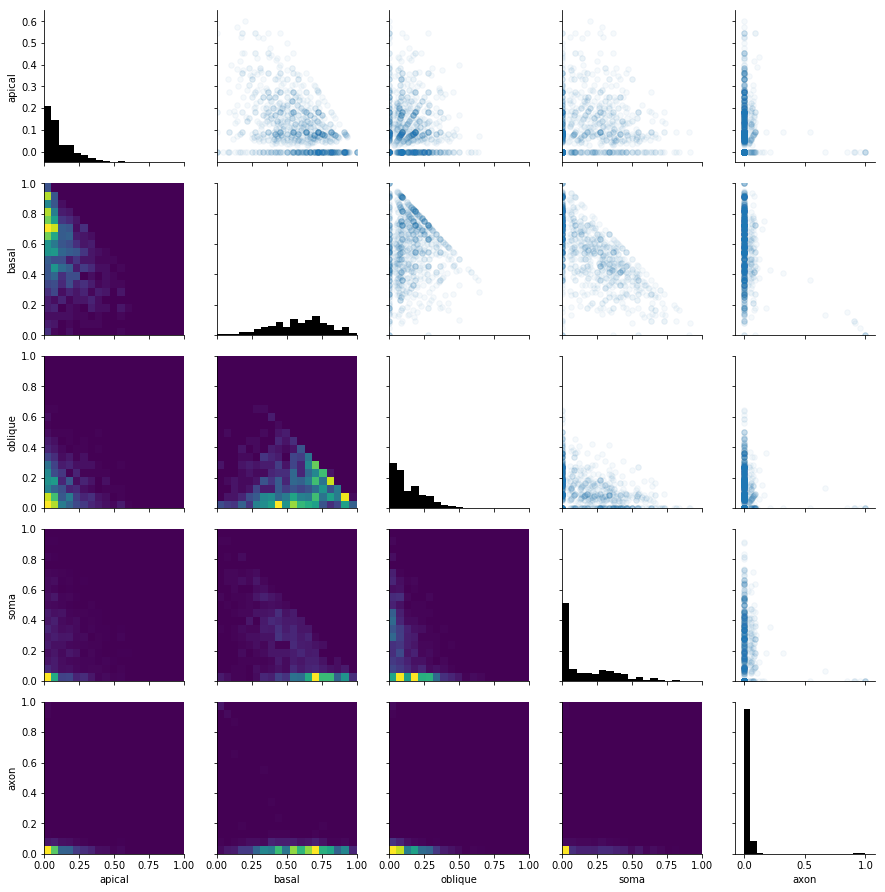

In [25]:
import matplotlib.colors as colors

X = np.array(df_normed[['apical','basal','oblique','soma','axon']])

g = sns.PairGrid(df_normed, vars=['apical','basal','oblique','soma','axon'])


# g.map_upper(plt.hist2d, bins=np.linspace(0,1,10), norm=colors.LogNorm(), linewidth=0)
g.map_upper(plt.scatter, s=30, alpha=50/len(df_normed))
g.map_lower(plt.hist2d, bins=np.linspace(0,1,20), linewidth=0)
g.map_diag(plt.hist, bins=np.linspace(0,1,20), color='k')

# g.fig.savefig('loghist.png', dpi=100)

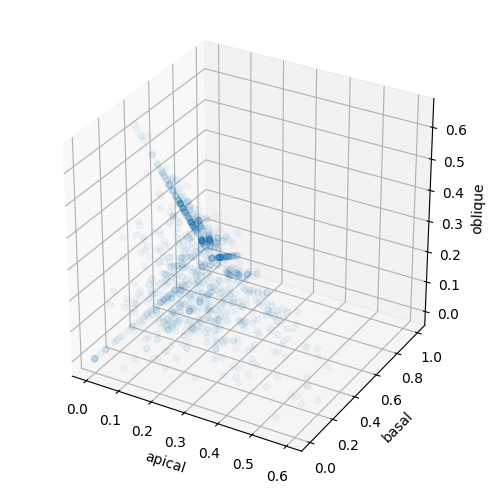

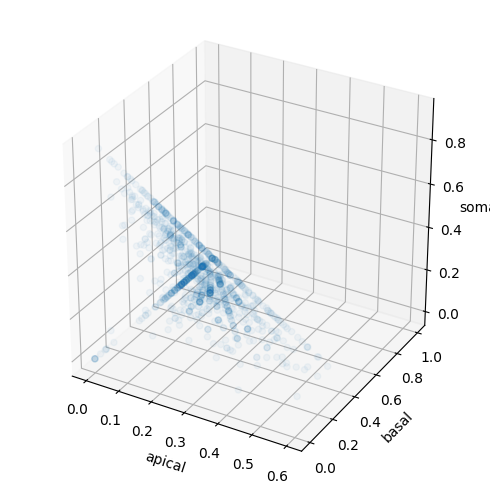

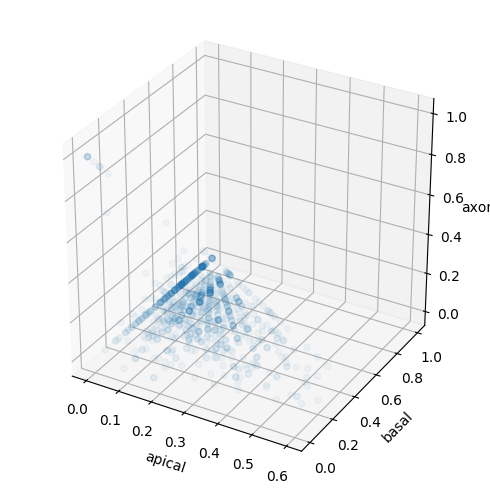

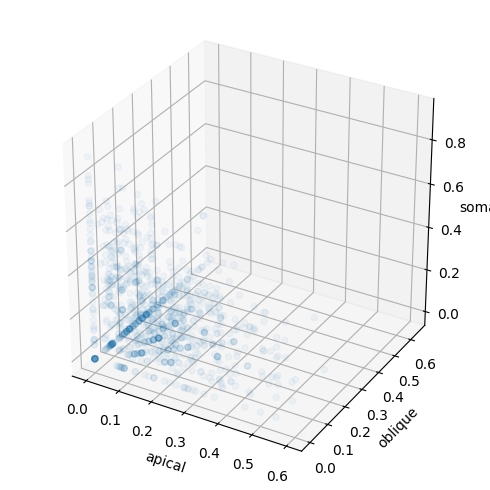

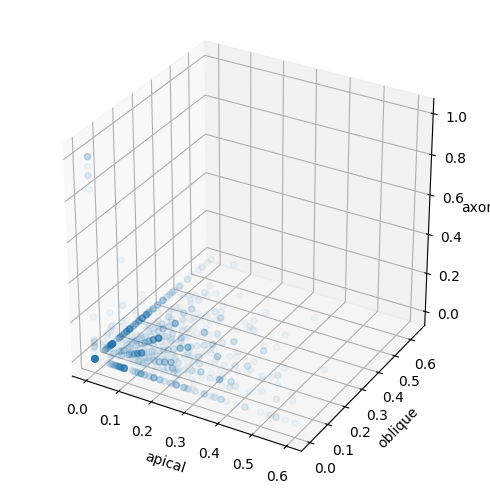

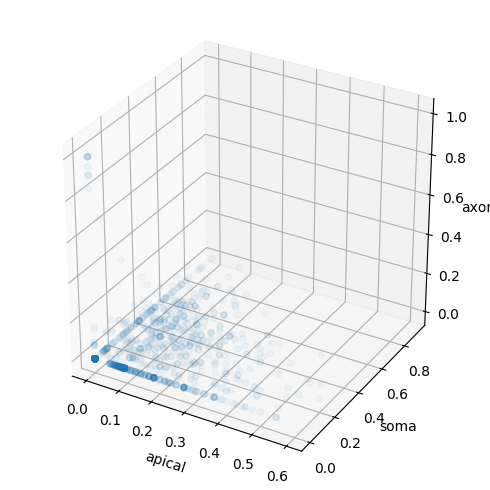

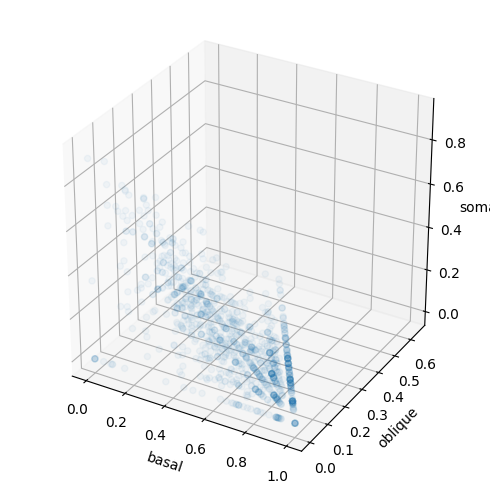

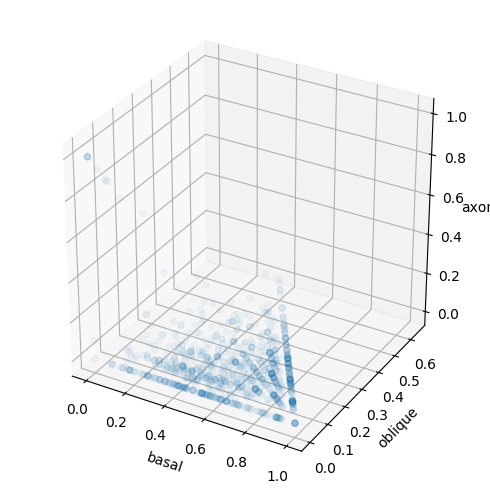

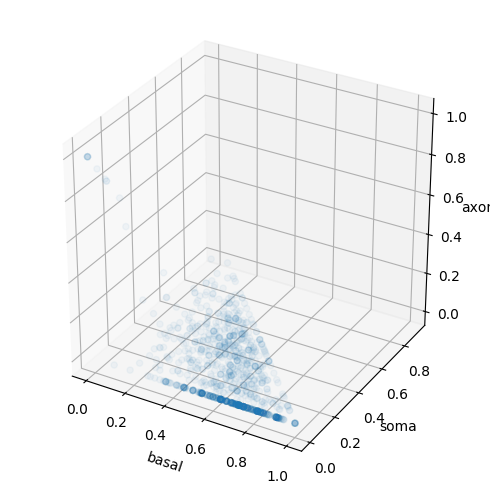

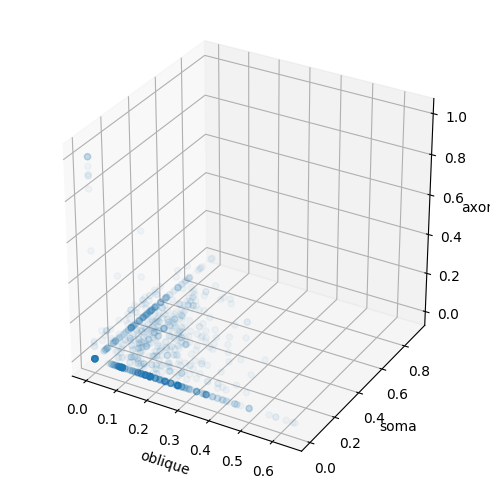

In [38]:
from itertools import combinations
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401 unused import

for x,y,z in combinations(['apical','basal','oblique','soma','axon'], 3):
    
    fig = plt.figure(figsize=(5,5), dpi=100)
    ax = fig.add_subplot(111, projection='3d')

    ax.scatter(df_normed[x], df_normed[y], df_normed[z], alpha=50/len(df_normed))
    ax.set_xlabel(x)
    ax.set_ylabel(y)
    ax.set_zlabel(z)
    fig.tight_layout()
# list()

array([[0.03949715, 0.        , 0.01962801, 0.01469575],
       [0.05623647, 0.        , 0.        , 0.        ],
       [0.05954194, 0.        , 0.        , 0.        ],
       ...,
       [0.0358387 , 0.        , 0.01723647, 0.02688068],
       [0.03464992, 0.00278435, 0.0256684 , 0.01225259],
       [0.03423015, 0.02249319, 0.        , 0.00884926]])

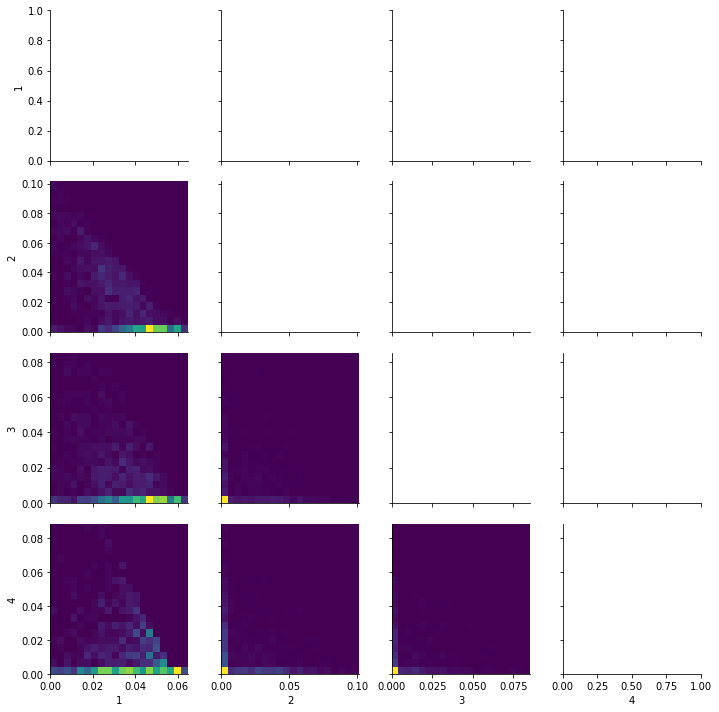

In [34]:
# from sklearn.decomposition import NMF
# # import matplotlib.colors as colors

# X = np.array(df_normed[['apical','basal','oblique','soma','axon']])
# model = NMF(n_components=4, alpha=.3, l1_ratio=.9)
# W = model.fit_transform(X)
# W.shape
# model.components_

# df_transform = pd.DataFrame(data=W, index=df.index, columns=[f'{i+1}' for i in range(W.shape[1])])
# g = sns.PairGrid(df_transform)
# g.map_lower(plt.hist2d, bins=20, linewidth=0)
# # g.map_diag(plt.hist, bins=np.linspace(0,1,20), color='k')
# W

In [157]:
# from sklearn.decomposition import KernelPCA
# X = np.array(df_normed[['apical','basal','oblique','soma','axon']])
# kpca = KernelPCA(kernel="poly", fit_inverse_transform=False, degree=3, 
#                  remove_zero_eig=True, n_components=4)
# Z = kpca.fit_transform(X)
# df_kpca = pd.DataFrame(data=Z, index=df_normed.index, columns=[f'pc{i+1}' for i in range(Z.shape[1])])
# sns.pairplot(df_kpca, kind='scatter')